# Introduction to Quantitative Trading - Building a Machine Learning Model

## Importing some libraries

In [223]:
import pandas as pd
import yfinance as yf
import numpy as np
import talib as ta
import plotly.express as px
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

np.random.seed(42)
pd.options.mode.chained_assignment = None

## Defining the parameters

In [224]:
# Get the data for the stock
start_date = '2012-01-01'
end_train = '2017-12-31'
end_date = '2023-12-31'
ticker = 'AAPL'

df = yf.download(ticker, start=start_date, end=end_date)

/Users/gw/workspace/quantitative-finance/venv/lib/python3.9/site-packages/yfinance/utils.py:775: FutureWarning:

The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.

[*********************100%%**********************]  1 of 1 completed


## Data Preprocessing

In [225]:
df["Adj Low"] = df["Low"] - (df["Close"]-df["Adj Close"])
df["Adj High"] = df["High"] - (df["Close"]-df["Adj Close"])

In [226]:
df["Returns"] = df["Adj Close"].pct_change()

df["Target"] = df["Returns"].shift(-1)
df["Target_cat"] = np.where(df["Target"] > 0, 1, 0)

## Feature Engineering

In [227]:
df["std15"] = df["Adj Close"].rolling(15).std()
df["moving_average"] = df["Adj Close"].rolling(15).mean()


df["zscore"] = (df["Adj Close"]-df["moving_average"])/df["std15"]
df["aroon"] = ta.AROONOSC(df["Adj High"], df["Adj Low"], timeperiod=14)

df["price_trend"] = df["Returns"].shift().rolling(4).sum()

In [228]:
df["zscore"] = pd.qcut(df["zscore"], 6, labels = False)
df["aroon"] = pd.qcut(df["aroon"], 4, labels = False)
df["price_trend"] = pd.qcut(df["price_trend"], 6, labels = False)

In [229]:
# let's drop the NaN values resulting from the rolling calculations
df = df.dropna()

In [230]:
features = ["aroon", "zscore", "price_trend"]

In [231]:
df[features].head()

,aroon,zscore,price_trend
Date,,,
2012-01-24,2.0,2.0,3.0
2012-01-25,3.0,5.0,1.0
2012-01-26,3.0,5.0,5.0
2012-01-27,2.0,5.0,5.0
2012-01-30,2.0,5.0,5.0


## Building the Model

In [232]:
# train test split
X_train, X_test = df[features].loc[start_date:end_train], df[features].loc[end_train:end_date]
y_train, y_test = df["Target_cat"].loc[start_date:end_train], df["Target_cat"].loc[end_train:end_date]

In [233]:
X_train.head()

,aroon,zscore,price_trend
Date,,,
2012-01-24,2.0,2.0,3.0
2012-01-25,3.0,5.0,1.0
2012-01-26,3.0,5.0,5.0
2012-01-27,2.0,5.0,5.0
2012-01-30,2.0,5.0,5.0


In [234]:
model = XGBClassifier()

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Evaluating the Model

In [235]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.39      0.43       704
           1       0.54      0.64      0.59       804

    accuracy                           0.52      1508
   macro avg       0.52      0.51      0.51      1508
weighted avg       0.52      0.52      0.52      1508


## Backtesting the Model

In [236]:
df["train_test"] = np.where(df.index > end_train, "Test", "Train")

y_pred_all = model.predict(df[features])
df["Signal"] = np.where(y_pred_all == 1, 1, -1)

df["Model_Returns"] = df["Signal"] * df["Target"]

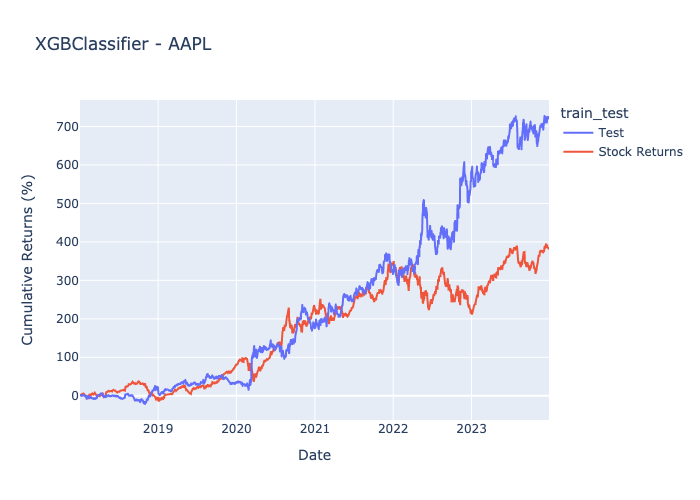

In [240]:
df_test = df[end_train:].dropna()

df_test["Model_Returns_Cumulative"] = (df_test["Model_Returns"] + 1).cumprod() - 1
df_test["Returns_Cumulative"] = (df_test["Returns"] + 1).cumprod() - 1


fig = px.line(df_test, x=df_test.index, y=df_test["Model_Returns_Cumulative"]*100, color="train_test",
              labels={"y": "Cumulative Returns (%)"},
              title=f"{model.__class__.__name__} - {ticker}",
              line_shape="linear")


fig.add_scatter(x=df_test.index, y=df_test["Returns_Cumulative"]*100, mode="lines", name="Stock Returns")


fig.show("png")

In [239]:
df_test.tail()

,Open,High,Low,Close,Adj Close,Volume,Adj Low,Adj High,Returns,Target,...,std15,moving_average,zscore,aroon,price_trend,train_test,Signal,Model_Returns,Model_Returns_Cumulative,Returns_Cumulative
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-21,196.100006,197.080002,193.500000,194.679993,194.431885,46482500,193.251892,196.831894,-0.000770,-0.005547,...,2.496850,194.435896,2.0,2.0,1.0,Test,-1,0.005547,7.244784,3.866200
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.353287,37122800,192.723282,195.163284,-0.005547,-0.002841,...,2.333766,194.593029,1.0,2.0,1.0,Test,1,-0.002841,7.221361,3.839205
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.803986,28919300,192.583984,193.643982,-0.002841,0.000518,...,1.877911,194.834056,1.0,2.0,1.0,Test,1,0.000518,7.225619,3.825457
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.903839,48087700,190.843842,193.253845,0.000518,0.002226,...,1.896146,194.816078,1.0,0.0,1.0,Test,-1,-0.002226,7.207307,3.827956
2023-12-28,194.139999,194.660004,193.169998,193.580002,193.333298,34049900,192.923294,194.413300,0.002226,-0.005424,...,1.791135,194.899969,1.0,0.0,1.0,Test,-1,0.005424,7.251824,3.838705


In [238]:
def CAGR(returns:pd.Series):
    trading_days = 252
    n = len(returns)/ trading_days
    cagr = ((1 + returns).cumprod()[-1])**(1/n) - 1
    return cagr

def volatility(returns:pd.Series):
    trading_days = 252
    vol = returns.std() * np.sqrt(trading_days)
    return vol


def sharpe_ratio(returns:pd.Series,rf):
    sharpe = (CAGR(returns) - rf)/ volatility(returns)
    return sharpe

print("Model: ", sharpe_ratio(df_test["Model_Returns"],0))
print("Buy&Hold: ", sharpe_ratio(df_test["Returns"],0))

Model:  1.3366744371187236
Buy&Hold:  0.951420881571789


/var/folders/g8/yxggp4955pb8fc_3g_ctdhjm0000gq/T/ipykernel_1703/1341515934.py:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

